# AI达人创造营作业：水果蔬菜分类

### 解压数据集

In [1]:
!unzip -q -d data/ data/data104366/Fruit-Vegetables-Dataset.zip

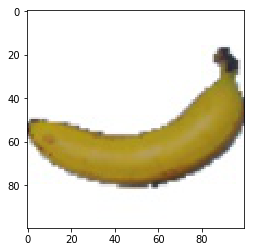

In [29]:
import matplotlib.pyplot as plt
import PIL.Image as Image

path = 'data/Fruit-Vegetables-Dataset/Banana/245_100.jpg'
img = Image.open(path)
plt.imshow(img)      # 根据数组绘制图像
plt.show()           # 显示图像

### 数据处理

In [22]:
import os
import re
images_path = 'data/Fruit-Vegetables-Dataset'   # 存放目录
txt_save_path = 'label_name.txt'  # 生成txt文件
fw = open(txt_save_path, "w")
# 读取函数，用来读取文件夹中的所有函数，输入参数是文件名

def read_directory(directory_name):
	i = 0
	for filename in os.listdir(directory_name):
		# print(filename)  # 仅仅是为了测试
		fw.write(filename + '\t' + str(i) +'\n')  # 打印成功信息
		i = i + 1

read_directory(images_path)    #传入所要读取文件夹路径

In [20]:
# 建立样本数据读取路径与样本标签之间的关系
import os
import random

data_list = []     # 用列表保存每个样本的读取路径和标签

# 构造标签字典
label_list = []    
with open('label_name.txt') as f:
    for line in f:
        a, b = line.strip('\n').split('\t')
        label_list.append([a, b])
label_dic = dict(label_list)

label_list_2 = []  
with open('label_name.txt') as f:
    for line in f:
        a, b = line.strip('\n').split('\t')
        label_list.append([b, a])

# 获取img_trainA目录下所有子目录名称，保存到列表中
class_list = []
for i in os.listdir('data/Fruit-Vegetables-Dataset'):
    class_dir = os.path.join('data/Fruit-Vegetables-Dataset', i)
    if os.path.isdir(class_dir):
        class_list.append(i)
# print(class_list)
# 方法二
# class_list = os.listdir('img_trainA')
# class_list.remove('label_name.txt')
# print(class_list)
for i in range(0,20):
    for each in class_list:
        for f in os.listdir('data/Fruit-Vegetables-Dataset/'+each):
            data_list.append(['data/Fruit-Vegetables-Dataset/'+ each +'/'+ f,label_dic[each]])

# 打乱文件顺序
random.shuffle(data_list)

# 打印前十个，[样本读取路径，样本标签]
print(data_list[0:10])

# 打印样本数量
print('样本数量是：{}'.format(len(data_list)))



[['data/Fruit-Vegetables-Dataset/Melon Piel de Sapo/r2_84_100.jpg', '34'], ['data/Fruit-Vegetables-Dataset/Orange/164_100.jpg', '23'], ['data/Fruit-Vegetables-Dataset/Banana Red/r_184_100.jpg', '33'], ['data/Fruit-Vegetables-Dataset/Nectarine Flat/r_199_100.jpg', '1'], ['data/Fruit-Vegetables-Dataset/Hazelnut/r_194_100.jpg', '97'], ['data/Fruit-Vegetables-Dataset/Apple Red Delicious/112_100.jpg', '89'], ['data/Fruit-Vegetables-Dataset/Eggplant/31_100.jpg', '45'], ['data/Fruit-Vegetables-Dataset/Passion Fruit/r_39_100.jpg', '93'], ['data/Fruit-Vegetables-Dataset/Hazelnut/41_100.jpg', '97'], ['data/Fruit-Vegetables-Dataset/Grape White 2/78_100.jpg', '62']]
样本数量是：1229760


In [3]:
# 构造读取器与数据预处理
# 导入相关模块
import paddle
from paddle.vision.transforms import Compose, ColorJitter, Resize, Transpose, Normalize
from paddle.vision import transforms
import cv2
import numpy as np 
from PIL import Image
from paddle.io import Dataset

# 数据预处理
def preprocess(img):
    transform = Compose([
        # Resize(size=(100, 100)),
        # transforms.RandomHorizontalFlip(),            # 水平翻转
        # transforms.ColorJitter(0.05, 0.05, 0.05, 0.05),
        # transforms.RandomRotation(8),     # 随机旋转
        # transforms.RandomResizedCrop(size=(300,400), scale=(0.8, 1.0),),  # 随机剪裁
        # mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5], data_format='HWC'
        Normalize(mean=[127.5, 127.5, 127.5], std=[127.5, 127.5, 127.5], data_format='HWC'),
        Transpose()
        ])
    img = transform(img).astype('float32')
    return img

# 自定义收据读取器
class Reader(Dataset):
    def __init__(self, data, is_val=False):
        super().__init__()
        self.samples = data[-int(len(data)*0.2):] if is_val else data[:-int(len(data)*0.2)]

    def __getitem__(self, idx):
        # 处理图像
        img_path = self.samples[idx][0]  # 得到某样本路径
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = preprocess(img)    # 数据预处理

        # 处理标签
        label = self.samples[idx][1]    # 得到某样本的标签
        label = np.array([label], dtype='int64')
        return img, label

    def __len__(self):
        # 返回每个epoch中的图片数量
        return len(self.samples)

# 生成训练数据集实例
train_dataset = Reader(data_list, is_val=False)

# 生成测试数据集实例
eval_dataset = Reader(data_list, is_val=True)

# 打印一个训练样本
print(train_dataset[88][0].shape)
print(train_dataset[88][1])


(3, 100, 100)
[79]


### 模型配置

In [4]:
# 定义模型
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super(MyNet, self).__init__()
        self.layer = paddle.vision.models.vgg16(pretrained=True)
        self.fc1 = paddle.nn.Linear(1000, 500)
        self.fc2 = paddle.nn.Linear(500, 120)
    # 网络的前向计算过程
    def forward(self, x):
        x = self.layer(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [5]:
# 模型配置
# 定义输入
input_define = paddle.static.InputSpec(shape=[-1,3,100,100], dtype='float32', name='img')
label_define = paddle.static.InputSpec(shape=[-1,1], dtype='int64', name='label')

# 实例化网络对象并定义优化器等
model = MyNet()
model = paddle.Model(model, inputs=input_define, labels=label_define)   # 封装模型
optimizer = paddle.optimizer.Adam(learning_rate=0.0003, parameters=model.parameters())

model.prepare(optimizer=optimizer,
              loss=paddle.nn.CrossEntropyLoss(),
              metrics=paddle.metric.Accuracy())


100%|██████████| 817517/817517 [00:11<00:00, 72781.77it/s]


### 模型训练

In [6]:
model.fit(train_data=train_dataset,
          eval_data=eval_dataset,
          batch_size=8,
          epochs=10,
          save_dir='output',
          save_freq=5,
          log_freq=10,
          verbose=1
          )

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 122976/122976 [==============================] - loss: 0.0711 - acc: 0.9187 - 25ms/step         
save checkpoint at /home/aistudio/output/0
Eval begin...
step 30744/30744 [==============================] - loss: 1.6778e-04 - acc: 0.9868 - 9ms/step     
Eval samples: 245952
Epoch 2/10
step 122976/122976 [==============================] - loss: 5.9605e-07 - acc: 0.9466 - 25ms/step        
Eval begin...
step 30744/30744 [==============================] - loss: 0.0063 - acc: 0.9765 - 9ms/step            
Eval samples: 245952
Epoch 3/10
step 122976/122976 [==============================] - loss: 0.0993 - acc: 0.9457 - 25ms/step         
Eval begin...
step 30744/30744 [==============================] - loss: 0.7395 - acc: 0.9830 - 9ms/step          
Eval samples: 245952
Epoch 4/10
step 122976/122976 [==============================] - loss: 0.0190 - acc: 0.9370 - 25ms/step            
Eval begin...
step 30744/30744 [==============================] - loss: 0.0220 - acc: 0.9807 - 9ms/step 

### 模型预测

In [7]:
# 加载模型
model.load('output/final')

result = model.evaluate(eval_dataset,
                        batch_size=128,
                        verbose=1)

print(result)


Eval begin...
step 1922/1922 [==============================] - loss: 0.0962 - acc: 0.9646 - 86ms/step         
Eval samples: 245952
{'loss': [0.096198305], 'acc': 0.9645581251626334}


In [8]:
result = model.predict(eval_dataset)
print(len(result[0]), result[0][0].shape)


# path = '  '
# img = Image.open(path)
# plt.imshow(img)      # 根据数组绘制图像
# plt.show()           # 显示图像

Predict begin...
step 245952/245952 [==============================] - 7ms/step        
Predict samples: 245952
245952 (1, 120)


In [ ]:
# for i in range(len(result[0])):
import matplotlib.pyplot as plt
for i in range(0,4):
    img1 = eval_dataset[i][0]
    img1 = img1.transpose(1, 2, 0)
    plt.imshow(img1)      # 根据数组绘制图像
    plt.show()           # 显示图像
    # print(img1.shape, eval_dataset[i][1], result[0][i])
    print(img1.shape, label_list_2[0][int(eval_dataset[i][1])])